## Práctica 1
### Elizaveta Gilyarovskaya
### Ejercicio 2: Contar monedas

In [2]:
from PIL import Image
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors

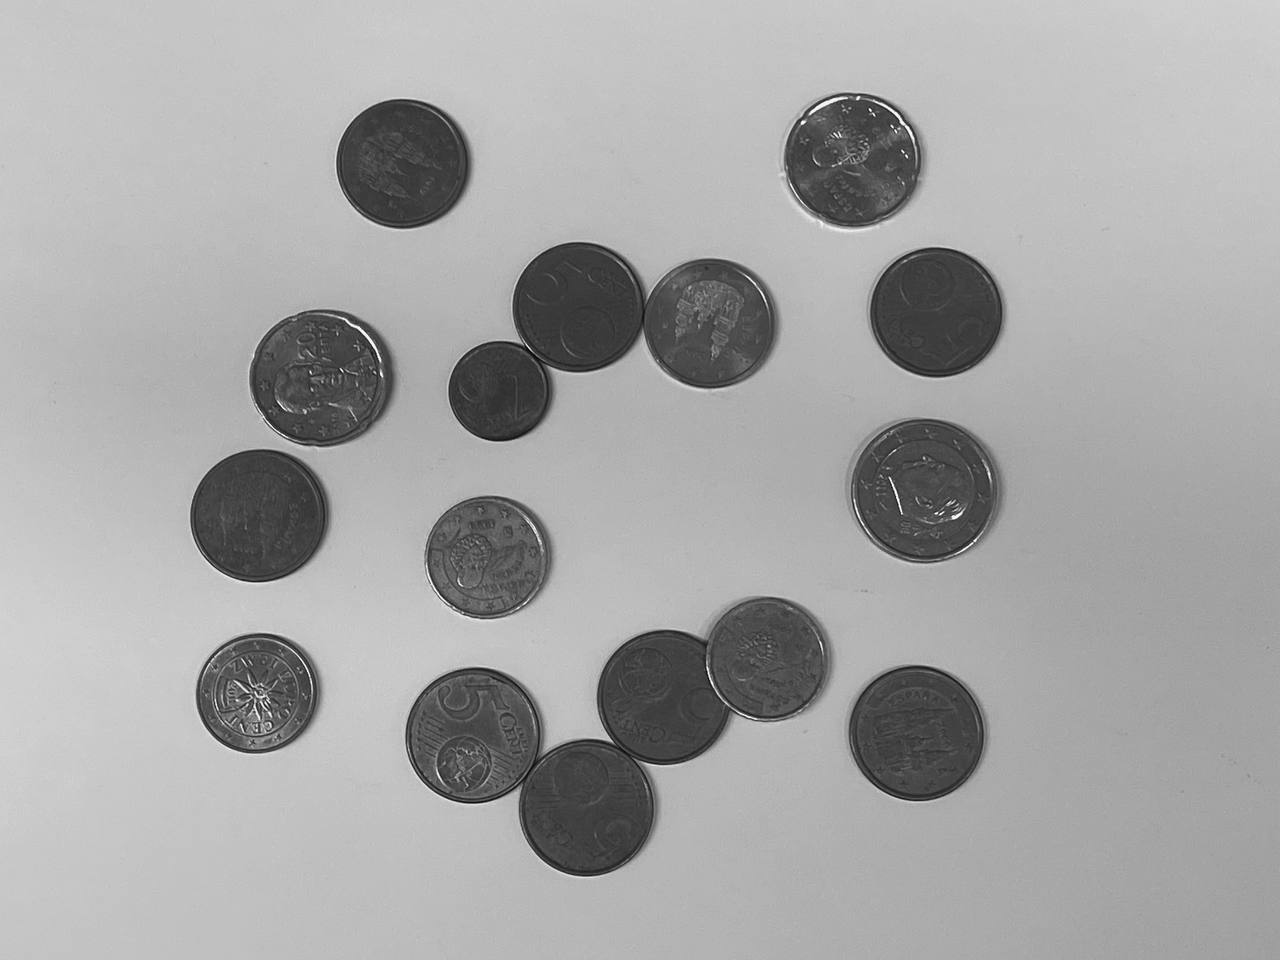

In [5]:
imagenes = [i for i in os.listdir() if i[-3::]== 'png']
mon = Image.open(imagenes[6])
# Convertimos la imagen RGB a otro espacio de color donde tengamos en un plano la “luminancia”, como LAB.
# Asi solo utilizaremos la componente de luminaria, en este caso L.
if mon.mode != "L":
    mon = mon.convert("L")
    
im = np.array(mon)
Image.fromarray(im)

### EL primer paso que haré es calcular y aplicar Otsu para pasarlo a binario.

In [11]:
def Otsu(im:np.ndarray):
    f = np.array([np.count_nonzero(im == i) for i in range(256)])
    probs = f / im.size #vectores de probabilidades de cada nivel de gris
    disp = []
    for t in range(0,255):
        p0 = np.sum(probs[0:t])#es la cantidad relativa de píxeles por debajo del umbral
        p1 = 1 - p0
        if p0>0 and p1>0:
            v0 = np.var(im[im<t])
            v1 = np.var(im[im>=t])
            d = p0*v0+p1*v1
            disp.append(d)
        else:
            disp.append(float('inf'))
    t =  np.argmin(disp)
    return t

129


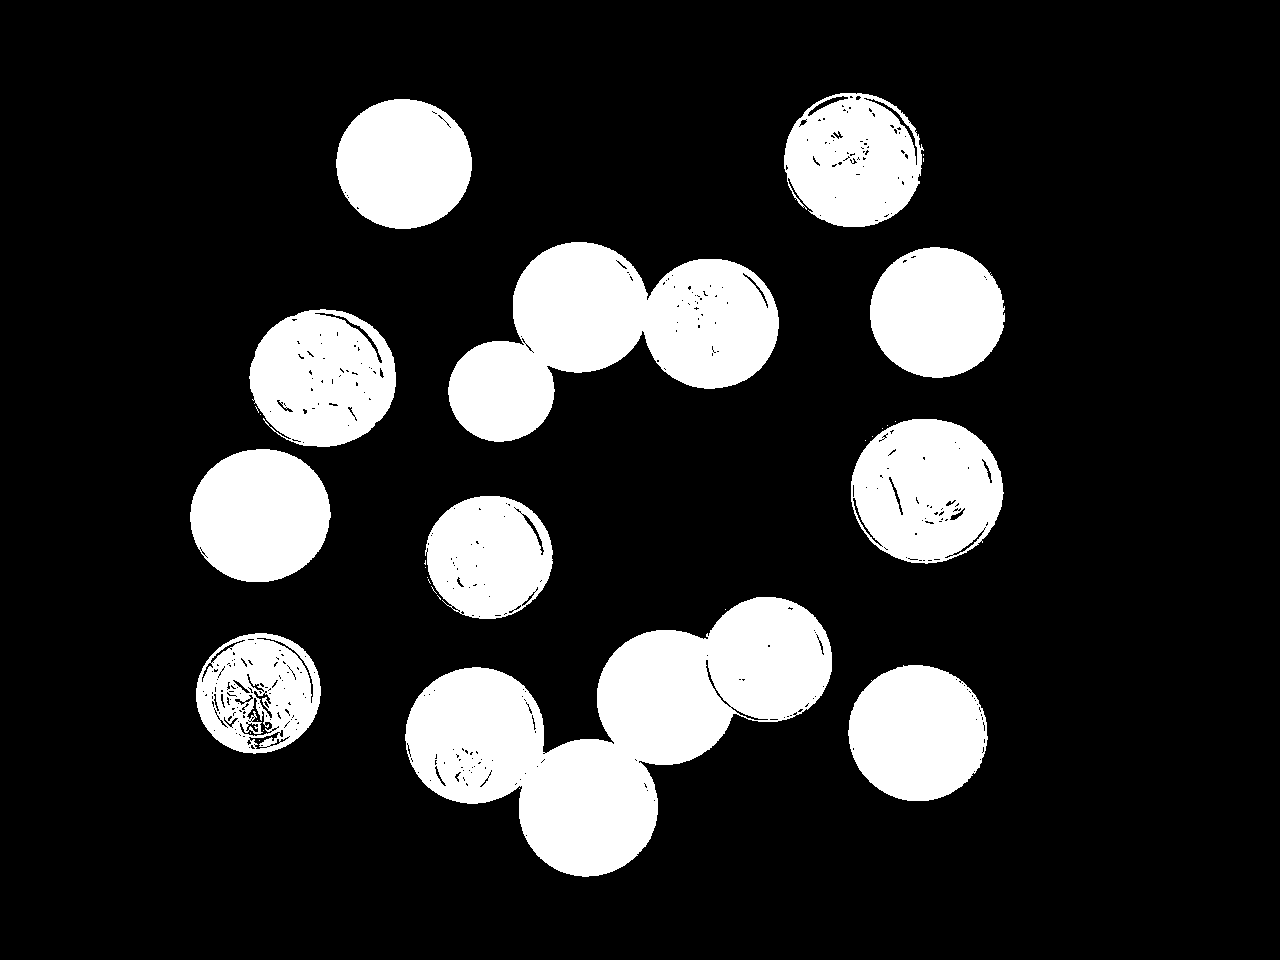

In [12]:
t = Otsu(im)
print(t)
mask = np.zeros(im.shape)
mask[im<t] = 255
mask = np.uint8(mask)
Image.fromarray(mask)

### Ahora que esta en binario y en negativo, aplico el filtro de Cierre con kernel de dilatado 4 y kernel de erosionado de 80 para intentar separar las monedas solapadas. 

In [59]:
def Dilatado(I, kernel_size):
    kernel_size = 3 if kernel_size < 3 else kernel_size

    kernel = np.full(shape=(kernel_size, kernel_size), fill_value=255)
    
    pad_width = kernel_size - 2 # tamaño óptimo de padding para la superposición del kernel

    # Aplicamos padding de tamaño óptimo
    padded = np.pad(array=I, pad_width=pad_width, mode='constant')
   
    
    # sub matrices of kernel size
    submatrices = np.array(
        [padded[i:(i + kernel_size), j:(j + kernel_size)]
        for i in range(padded.shape[0] - pad_width*2) for j in range(padded.shape[1] - pad_width*2)
        ])

    # condition to replace the values - if the kernel equal to submatrix then 255 else 0
    dilated = np.array([255 if (i == kernel).any() else 0 for i in submatrices])
    dilated = dilated.reshape(I.shape)
    dilated = np.uint8(np.clip(dilated,0,255))
    
    return dilated

def Erosionado(I, kernel_size):
    kernel_size = 3 if kernel_size < 3 else kernel_size

    kernel = np.full(shape=(kernel_size, kernel_size), fill_value=255)
    
    pad_width = kernel_size - 2 # tamaño óptimo de padding para la superposición del kernel

    # Aplicamos padding de tamaño óptimo
    padded = np.pad(array=I, pad_width=pad_width, mode='constant')
   
    
    # sub matrices of kernel size
    submatrices = np.array(
        [padded[i:(i + kernel_size), j:(j + kernel_size)]
        for i in range(padded.shape[0] - pad_width*2) for j in range(padded.shape[1] - pad_width*2)
        ])

    # condition to replace the values - if the kernel equal to submatrix then 255 else 0
    image_erode = np.array([255 if (i == kernel).all() else 0 for i in submatrices])
    image_erode = image_erode.reshape(I.shape)
    image_erode = np.uint8(np.clip(image_erode,0,255))
    
    return image_erode


def Cierre(I, kernel_size_dilatado, kernel_size_erosionado):
    return Erosionado(Dilatado(I,kernel_size_dilatado), kernel_size_erosionado)


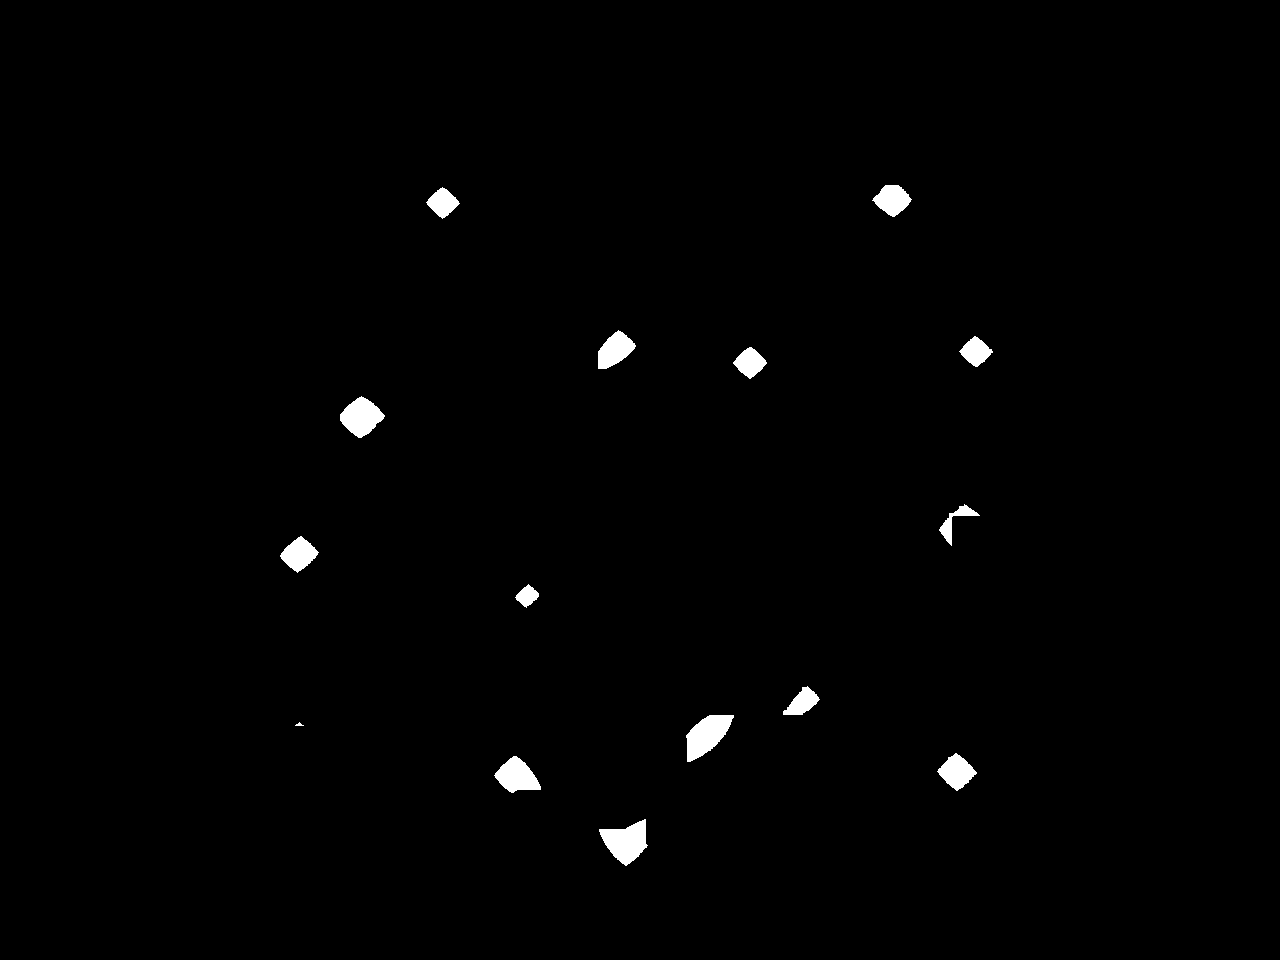

In [69]:
cierre = Cierre(mask,4,80)
Image.fromarray(cierre)

### Ahora dilato de nuevo las monedas resultantes:

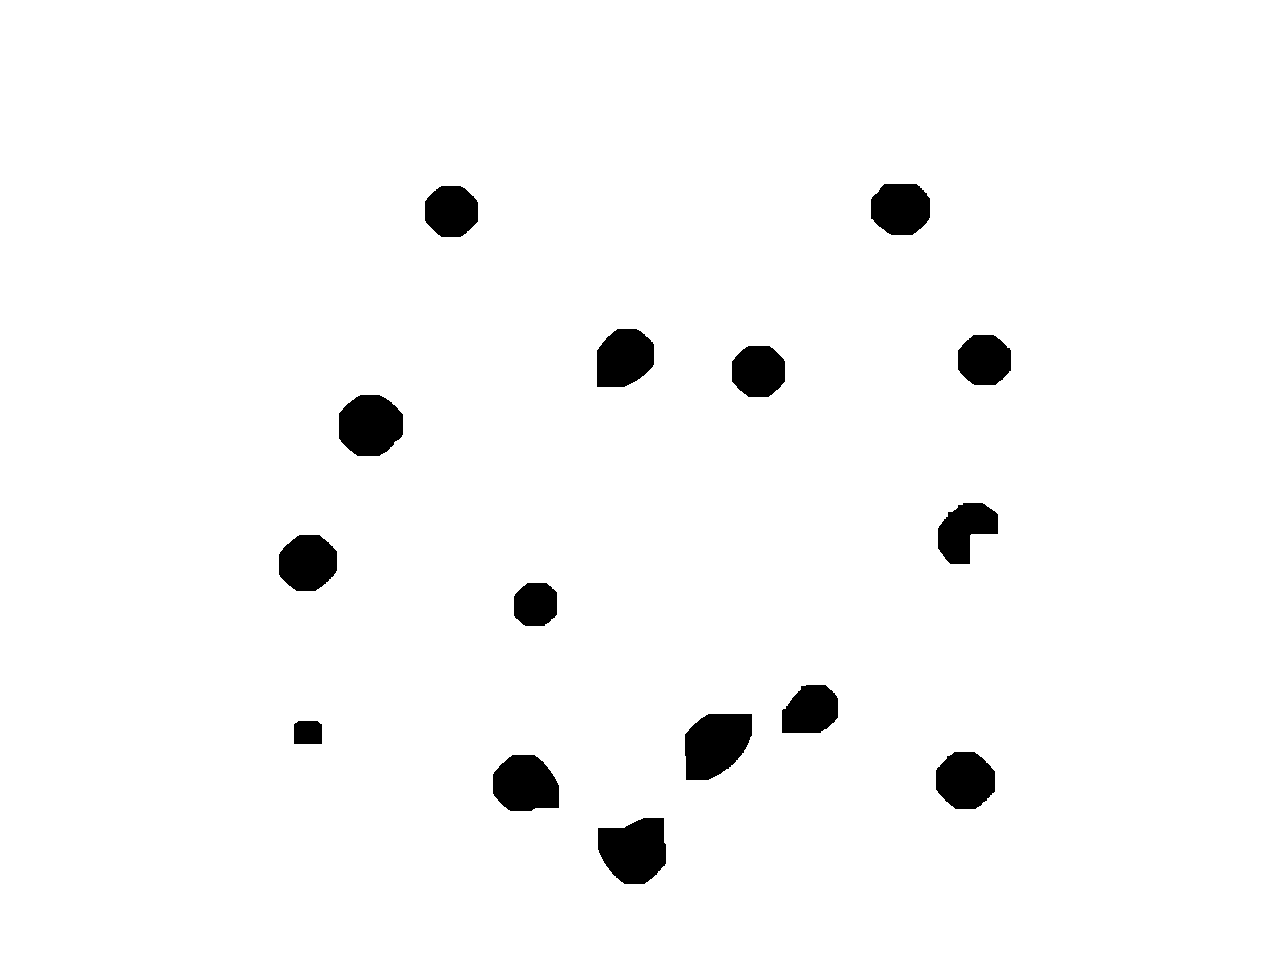

In [70]:
dilated = Dilatado(cierre, 20)
Image.fromarray(255-dilated)

### Ahora sacaré las componentes conexas:

In [71]:
def get_cc(G, nodes, edges): # recibe un set de tuplas de enteros que representan las aristas entre los nodos(pixeles)
    for n in nodes:
        G.add_node(n)
    for n1,n2 in edges:
        G.add_edge(n1,n2)
  
    return list(nx.connected_components(G)) 

def Label(im):
             
    def get_label(i,j):
        four_connected = [(i,j-1), (i-1, j)] #si fuera 8-conectadas añadir además (i-1,j-1), (i-1, j+1)]
        values = []
        for i, j in four_connected:
            if not(i>=0 and j>=0 and i<im.shape[0] and j<im.shape[1]): continue # si no se da, next iteration
                
            #res inialmente se llena de pixeles de valor backgroud
            if res[i,j] != background: 
                values.append(int(res[i,j]))
        if len(values) == 0: 
            return prev_label + 1
        
        values = tuple(sorted(set((values))))
        ## Añadimos nuevos edges
        for edge_i in values[:-1]:
            for edge_j in values[1:]:
                edges.add((edge_i, edge_j))
        
        return values[0]
            
    b = int(input('Si el fondo es negro (imagen en negativo) introduzca 0, sino 1: '))
    background = 0 if b == 0 else 255
    G = nx.Graph()
    edges = set()
    nodes = set()
    prev_label = 0
    res = np.full((im.shape[0], im.shape[1]), background) 

    # 1: definimos y etiquetamos equivalencias
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i,j] != background:
                res[i,j] = get_label(i,j) #se saca la etiqueta de la componente correspondiente y se actualiza edges
                
                #Actualizamos la última equivalencia conocida
                if res[i,j] > prev_label:
                    prev_label = res[i,j]
                    
    # 2: resolvemos equivalencias
    for e in edges:
        nodes.update(e)
    connected_components = get_cc(G, nodes, edges)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for index, component in enumerate(connected_components):
                if res[i,j] in component:
                    res[i,j] = index +1
    
    # COLOREAR LAS COMPONENTES
    coloured_res = np.full((res.shape[0], res.shape[1], 3), background) #se puede devolver en positivo o en negativo dependiendo del background
    values = [mcolors.to_rgb(i) for i in mcolors.TABLEAU_COLORS.values()]    
    values = [(int(255*r), int(255*g), int(255*b)) for r,g,b, in values]
    colors = values[0:len(connected_components)]
    for index, color in enumerate(colors):
        connected_comp = index +1
        coloured_res[res == connected_comp,] = color
    
    return np.uint8(coloured_res),np.uint8(res) # devuelvo la versión coloreada y la gris 


In [72]:
labeled_color, labeled = Label(255-dilated)

Si el fondo es negro (imagen en negativo) introduzca 0, sino 1: 1


In [75]:
print(f"Hay {len(np.unique(labeled))} monedas")

Hay 16 monedas
